In [41]:
%load_ext autoreload
%autoreload 2
import torch
import utils as u
import main as m
from matplotlib import pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

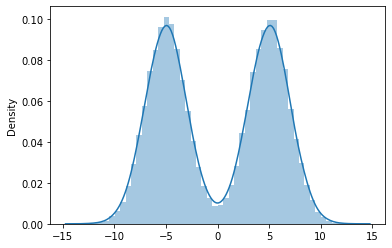

In [42]:
gen_model = u.NormalMixture1D([0.5,0.5], means=[-5, 5], stds=[2,2])
sns.distplot(gen_model.sample(100000))

In [43]:
def get_traces(gen_model, num_traces, obs_std):
    x = gen_model.sample(num_traces)
    obs = torch.distributions.Normal(loc=x,scale=obs_std).sample((1,)).squeeze()
    return x, obs

/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

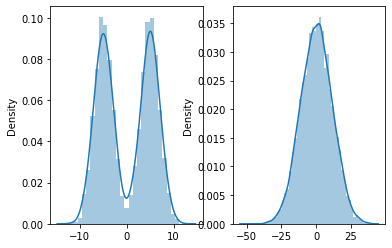

In [44]:
x, obs = get_traces(gen_model, 10000, 10.0)
fig, axes = plt.subplots(1,2)
sns.distplot(x,ax=axes[0])
sns.distplot(obs, ax=axes[1])

In [54]:
def amortize_inference(inference_network, gen_traces_fn, optimizer, num_iterations):
    loss_history = []
    for i in range(num_iterations):
        x, obs = gen_traces_fn()
        loss = inference_network(x, obs.unsqueeze(-1).unsqueeze(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_history.append(loss.item())

    return loss_history

In [ ]:
class SeqGaussMixPosterior(nn.Module):
    def __init__(self, num_mixtures):
        super().__init__()
        self.embed_obs = MLP(2, 10, output_size=10, unsqueeze=False)
        self.decode_mu = MLP(1, 12, input_size=10,
                             last_activation=lambda y: torch.tanh(y) * 10,
                             unsqueeze=False)
        self.decode_sigma = MLP(1, 12, input_size=10,
                                last_activation=torch.exp,
                                unsqueeze=False)
        self.decode_mixture_prob = MLP(1, 12, input_size=10,
                                       last_activation=torch.exp,
                                       unsqueeze=False)
        self.trans_dec = nn.TransformerDecoderLayer(d_model=10, nhead=2, dim_feedforward=20,
                                                    batch_first=True, dropout=0.0)

        self.start = torch.nn.Parameter(torch.rand(1, 1, 10))
        self.num_mixtures = num_mixtures

    def get_q_x_given_obs(self, obs):
        obs_embed = self.embed_obs(obs)
        so_far_decoded = self.start.expand(obs_embed.shape)
        all_mu, all_sigma, all_mix_p = [], [], []
        for _ in range(self.num_mixtures):
            obs_dec = self.trans_dec(so_far_decoded, obs_embed)
            so_far_decoded = torch.cat([so_far_decoded, obs_dec[:, -1:, :]], dim=-2).detach()
            all_mu.append(self.decode_mu(obs_dec[:, -1:, :]))
            all_sigma.append(self.decode_sigma(obs_dec[:, -1:, :]))
            all_mix_p.append(self.decode_mixture_prob(obs_dec[:, -1:, :]))
        mixture_probs =  torch.cat(all_mix_p, dim=1).reshape(len(obs),self.num_mixtures)
        mu = torch.cat(all_mu, dim=1).reshape(len(obs),self.num_mixtures)
        sigma = torch.cat(all_sigma, dim=1).reshape(len(obs),self.num_mixtures)
        return BatchedNormalMixture1D(mixture_probs/mixture_probs.sum(dim=1).unsqueeze(-1), mu, sigma)

    def forward(self, theta, obs):
        q_x_given_obs = self.get_q_x_given_obs(obs)
        log_prob = q_x_given_obs.log_prob(theta)
        return -torch.mean(log_prob)

In [59]:
gen_traces_fn = lambda: get_traces(gen_model, 1000, 10.0)
inference_network = m.SeqGaussMixPosterior(num_mixtures=2)
optimizer = torch.optim.Adam(params=inference_network.parameters())


losses = amortize_inference(inference_network, gen_traces_fn, optimizer, 10000)


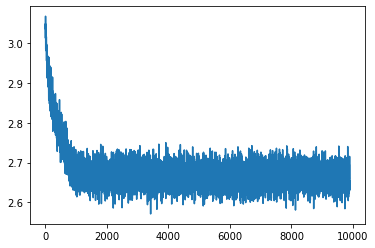

In [62]:
plt.plot(losses[100:])

tensor([[0.3644, 0.6356]], grad_fn=<DivBackward0>)
tensor([[-4.4981,  4.9371]], grad_fn=<ReshapeAliasBackward0>)
tensor([[1.9807, 1.9864]], grad_fn=<ReshapeAliasBackward0>)


/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


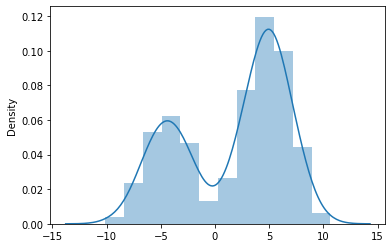

In [65]:
dist = inference_network.get_q_x_given_obs(torch.tensor([[[4.0]]]))

sns.distplot(u.NormalMixture1D(mixture_probs=dist.mixture_probs[0], 
                means=dist.normals.loc[0], 
                stds=dist.normals.scale[0]).sample(1000))

print(dist.mixture_probs)
print(dist.normals.loc)
print(dist.normals.scale)

0 0
1 0
1 1


[autoreload of main failed: Traceback (most recent call last):
  File "/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/aldo/intphys_for_rl/main.py", line 162
    def amortize_inference(inference_network, 